In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

def get_res_df(reports_path, monitor=False):
    df_ls1 = []
    file_list = sorted(os.listdir(reports_path))
    file_list = [file for file in file_list if 'report' in file and '.html' in file]
    for file in file_list:
        df_ls = pd.read_html(os.path.join(reports_path, file), flavor='bs4')
        if monitor:
            df = df_ls[2]
            if 'Memory(max) [MB]' in df.columns:
                cols = []
                for col in df.columns:
                    if 'MB' in col:
                        col = col.replace('MB', 'GB')
                    cols.append(col)
                df.columns = cols
                df[cols[3:5]] = df[cols[3:5]]/1000
        else:
            df=df_ls[0]
        df['Rate'] = int(file.split('-')[1])
        df_ls1.append(df)
    df1 = pd.concat(df_ls1)
    rates = sorted(df1.Rate.unique())
    df_ls2 = []
    for rate in rates:
        df_mean = df1[df1.Rate == rate].groupby('Name').mean().round(2)
        df_ls2.append(df_mean)
    df2 = pd.concat(df_ls2)
    return df2

def plot_perf(df: pd.DataFrame, withArrivalRate=False):
    roundLabels = ['open', 'query', 'transfer']
    metricLabels = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
    
    data = []
    for metric in metricLabels:
        values = []
        for index in roundLabels:
            res = df[df.index == index][metric].values
            values.append(res)
        data.append(values)
    
    rates = df[df.index == roundLabels[0]]['Rate'].values
    rows, cols = 1, 2
    fig, axs = plt.subplots(figsize=(16,5), ncols=cols, nrows=rows)
    axs[0].plot(rates, data[0][0], label='open', marker='*', color='C0')
    axs[0].plot(rates, data[0][1], label='query', marker='d', color='C1')
    axs[0].plot(rates, data[0][2], label='transfer', marker='<', color='C2')
    if withArrivalRate:
        axs[0].plot(rates, data[2][0], '--', label='open arrival rate', marker='*', color='C0')
        axs[0].plot(rates, data[2][1], '--', label='query arrival rate', marker='d', color='C1')
        axs[0].plot(rates, data[2][2], '--', label='transfer arrival rate', marker='<', color='C2')
    axs[0].set(title='Besu Throughput under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Throughput (TPS)')
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(rates, data[1][0], label='open', marker='*')
    axs[1].plot(rates, data[1][1], label='query', marker='d')
    axs[1].plot(rates, data[1][2], label='transfer', marker='<')
    axs[1].set(title='Besu Latency under Varying Send Rates', xticks=rates,
        xlabel='Transaction Send Rate (req/s)', ylabel='Latency (S)')
    axs[1].grid()
    axs[1].legend()

def plot_resource(df, jvm_max_heap):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    node_names = sorted(df.index.unique())
    metrics = df.columns[:4]
    for node in node_names:
        df_node = df[df.index == node]
        X = df_node.Rate.values
        # Y1 = df_node[metrics[2]].values
        # axes[0].plot(X, Y1, '--', marker='*', label=node+' '+metrics[2])
        Y2 = df_node[metrics[3]].values
        axes[0].plot(X, Y2, marker='d', label=node+' '+metrics[3])
        
        # Y3 = df_node[metrics[0]].values
        # axes[1].plot(X, Y3, '--', marker='*', label=node+' '+metrics[0])
        Y4 = df_node[metrics[1]].values
        axes[1].plot(X, Y4, marker='d', label=node+' '+metrics[1])
        
    axes[0].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='Memory Usage (GB)',
                title='Besu Node Memory Usage')
    axes[0].axhline(y=jvm_max_heap, color='r', linestyle='--', label='JVM MaxHeapSize')
    axes[0].grid()
    axes[0].legend()
    axes[1].set(xticks=X, xlabel='Transaction Send Rate (req/s)', ylabel='CPU Usage (%)',
            title='Besu Node CPU Usage')
    axes[1].grid()
    axes[1].legend()
    plt.show()

# 2c-7.5gb

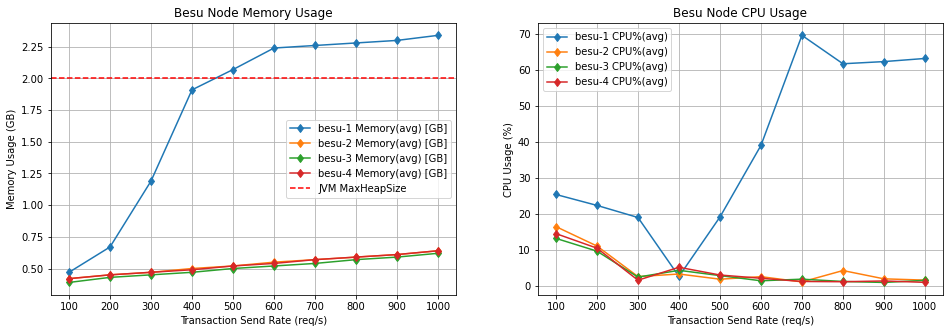

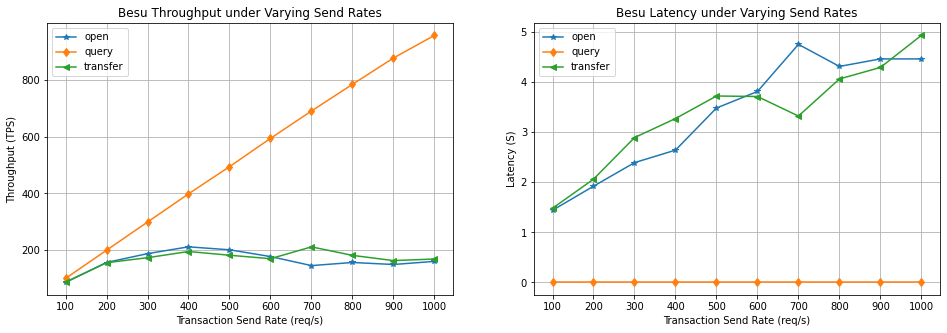

In [3]:
# small node 2c-7.5gb
reports_path = '../caliper-benchmarks/reports/20220307-165330-2c7.5gb-4'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=2)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

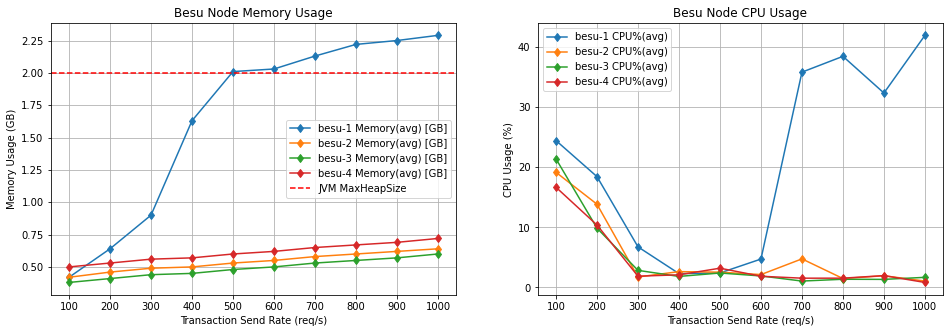

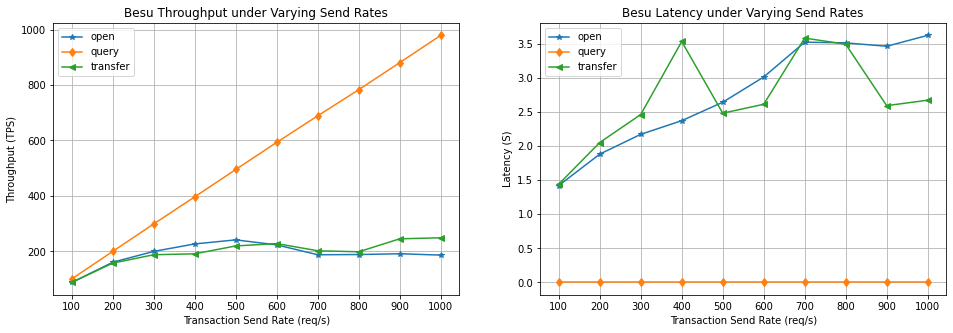

In [4]:
# small node 2c-7.5gb with maxrampercentage=80.0
reports_path = '../caliper-benchmarks/reports/20220322-172941-4n-2c7.5gb-ram80'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=2)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

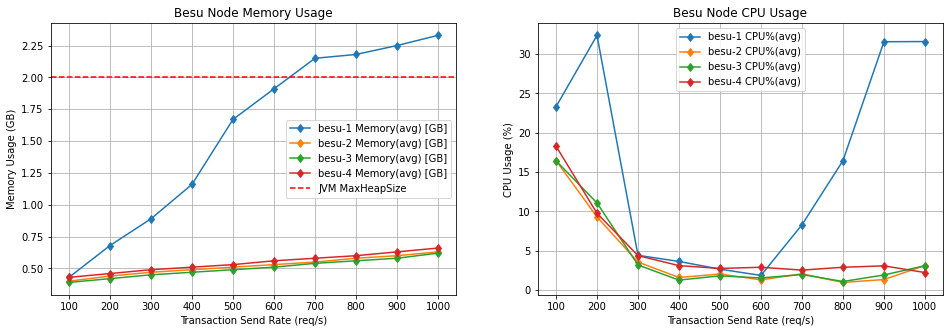

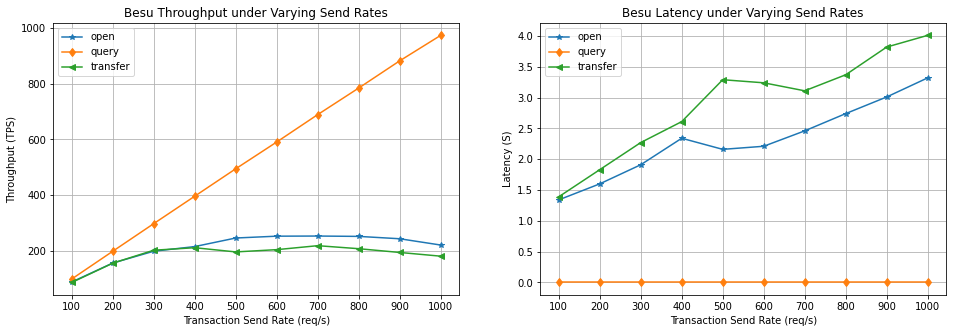

In [4]:
# small node 2c-7.5gb with maxrampercentage=50.0
reports_path = '../caliper-benchmarks/reports/20220323-181854-4n-2c7.5gb-ram50'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=2)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

## 50% MaxRamPercentage

VM settings:
    Max. Heap Size (Estimated): 3.64G
    Using VM: OpenJDK 64-Bit Server VM

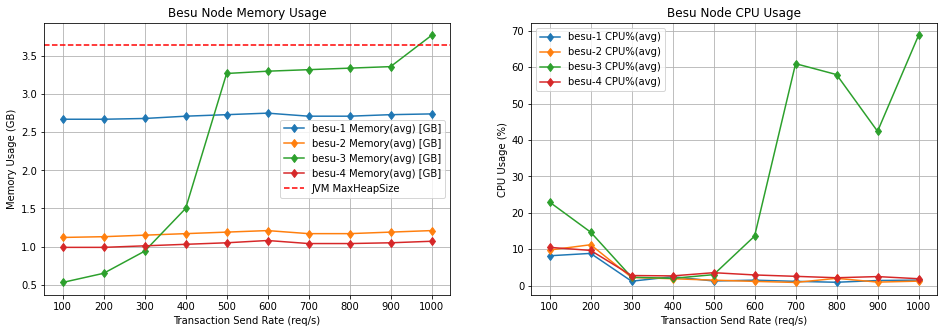

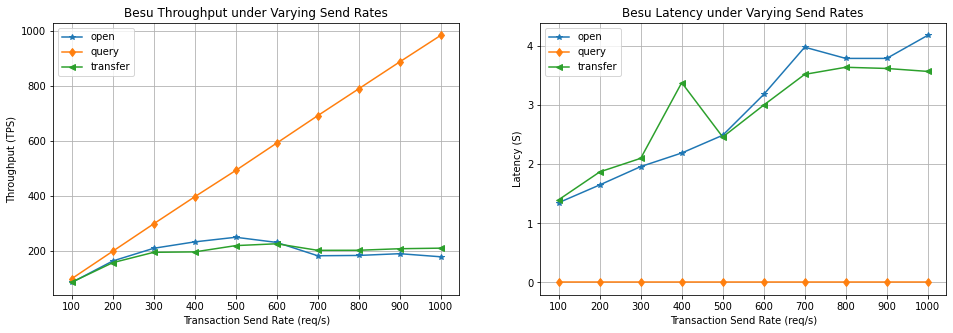

In [3]:
# small node 2c-7.5gb with maxrampercentage=50.0
reports_path = '../caliper-benchmarks/reports/20220326-003930-4n-2c-7.5gb-50ram'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=3.64)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

## 80% MaxRamPercentage
VM settings:
    Max. Heap Size (Estimated): 5.83G
    Using VM: OpenJDK 64-Bit Server VM

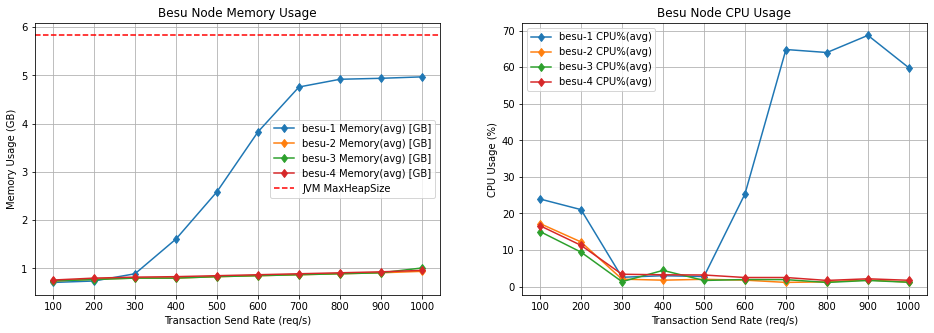

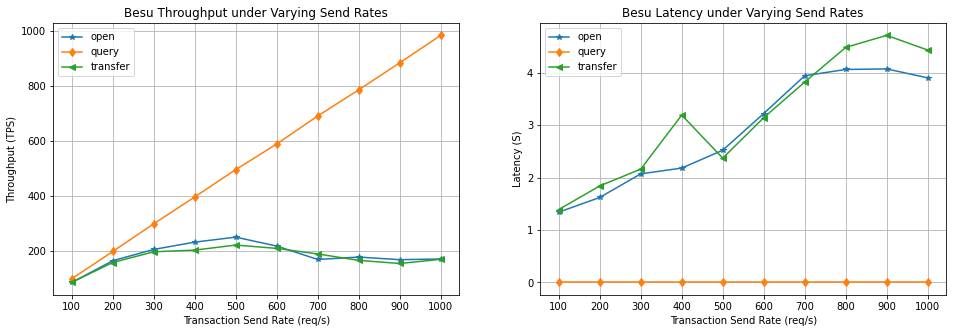

In [8]:
# small node 2c-7.5gb with maxrampercentage=80.0
reports_path = '../caliper-benchmarks/reports/20220328-151933-4n-2c7.5gb-80ram'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=5.83)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

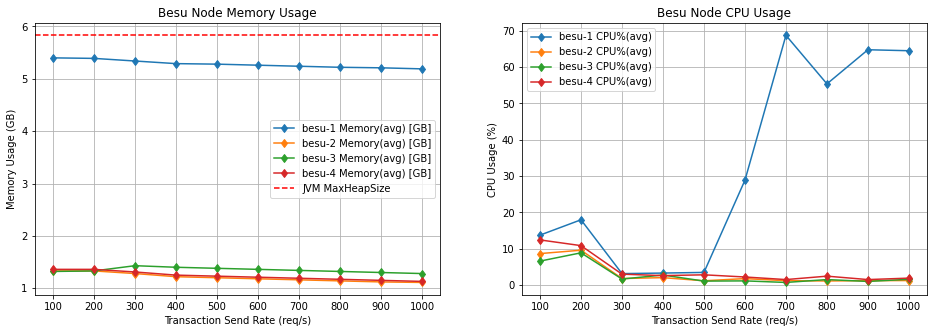

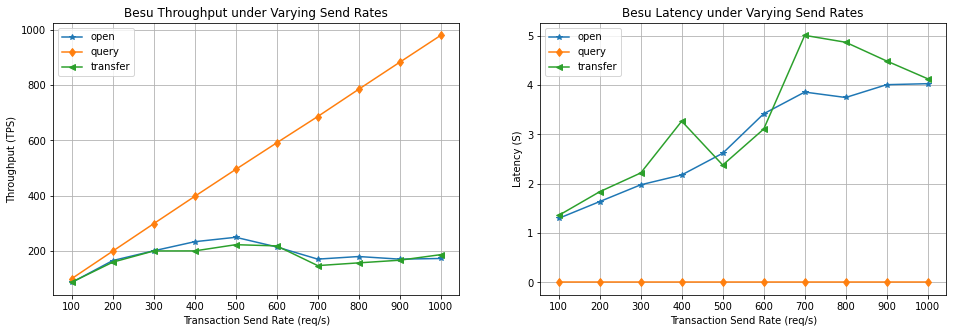

In [6]:
# small node 2c-7.5gb with maxrampercentage=80.0
reports_path = '../caliper-benchmarks/reports/20220328-193603'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=5.83)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

## Multiple Clients

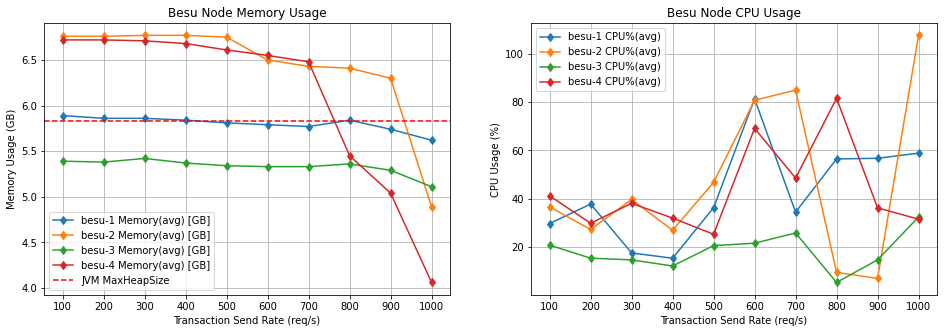

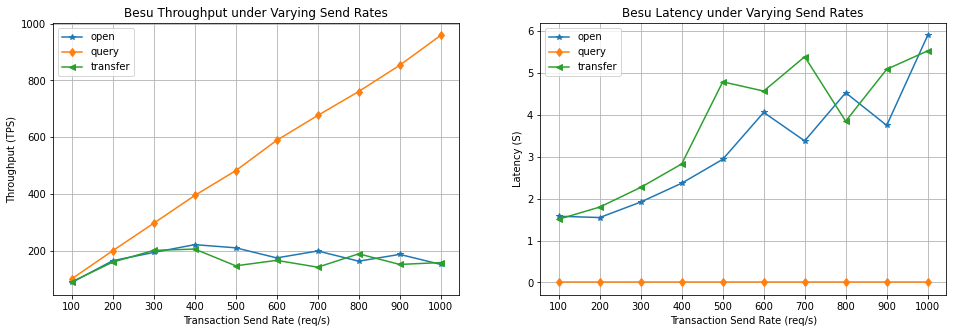

In [3]:
# small node 2c-7.5gb with maxrampercentage=80.0 multiple calipers
# client-1
reports_path = '../caliper-benchmarks/reports/20220329-211507-4n-2c7.5gb-80ram-client1'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=5.83)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

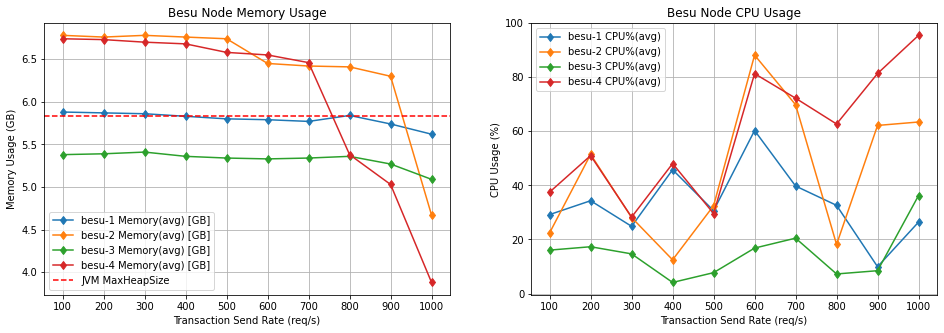

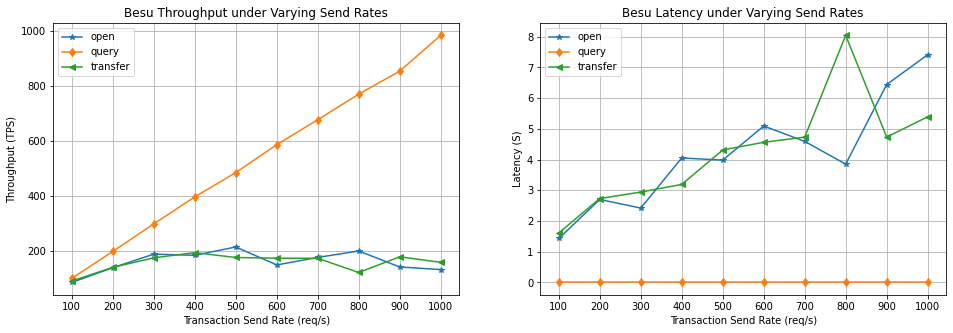

In [4]:
# small node 2c-7.5gb with maxrampercentage=80.0 multiple calipers
# client-4
reports_path = '../caliper-benchmarks/reports/20220329-211509-4n-2c7.5gb-80ram-client4'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=5.83)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

# 4c-15gb

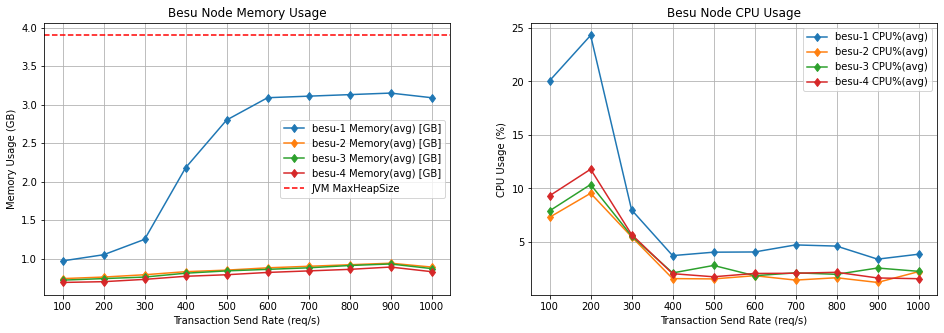

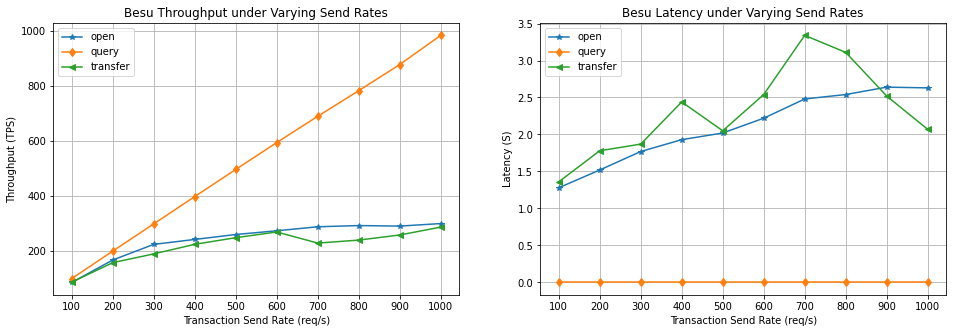

In [5]:
# 4c-15gb with maxrampercentage=80.0
reports_path = '../caliper-benchmarks/reports/20220322-154306-4n-4c15gb-ram80'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=3.9)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

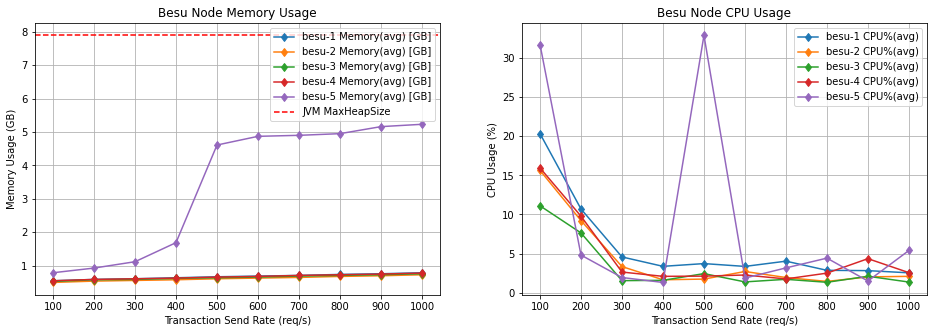

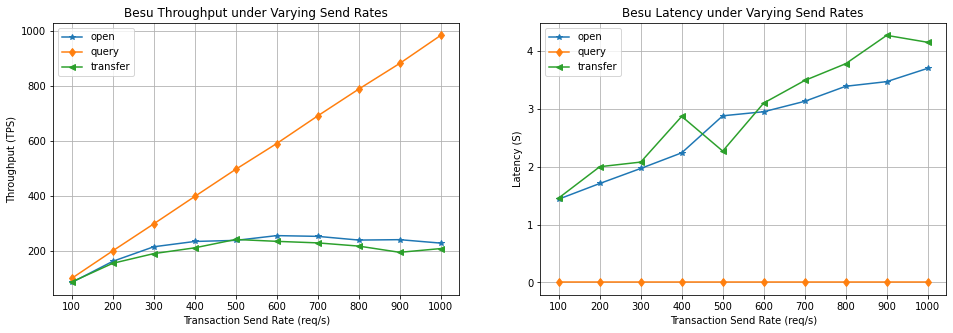

In [162]:
reports_path = '../caliper-benchmarks/reports/20220223-215241-5-2sec'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=7.89)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

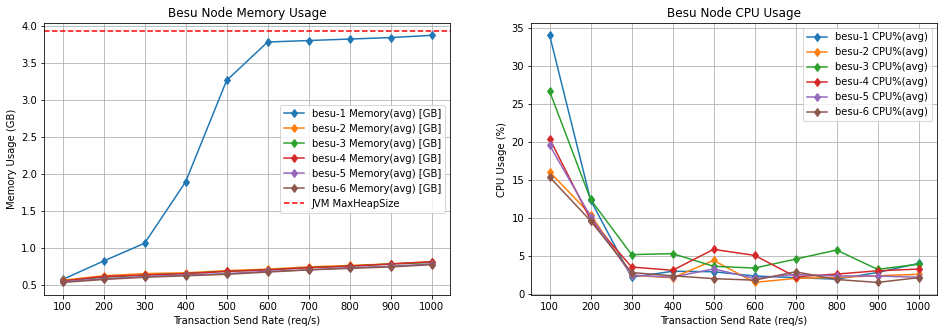

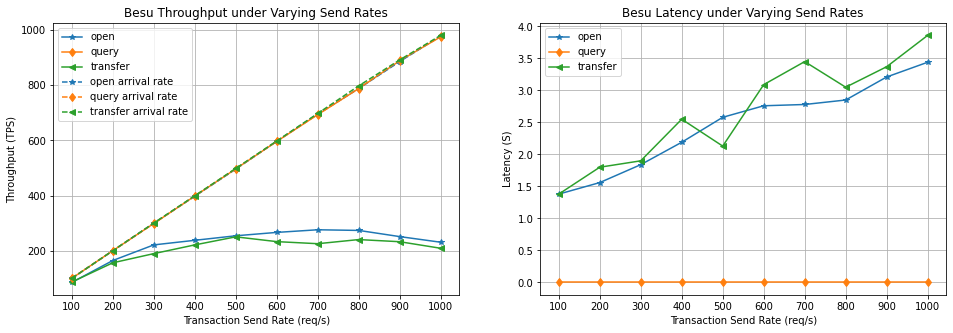

In [7]:
reports_path = '../caliper-benchmarks/reports/20220224-001139-6-2sec'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=3.93)

df_perf = get_res_df(reports_path)
plot_perf(df_perf, True)

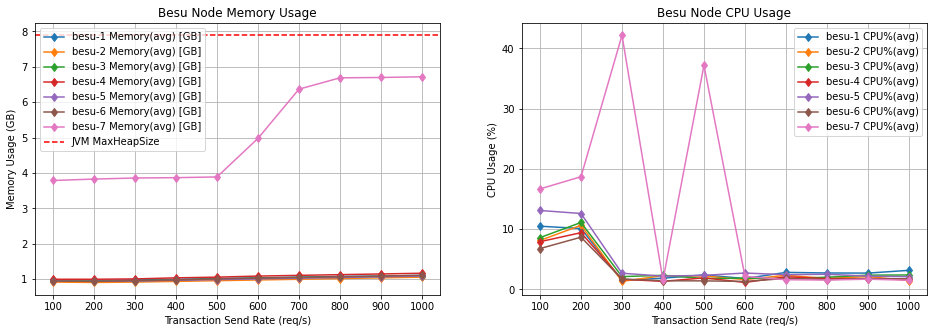

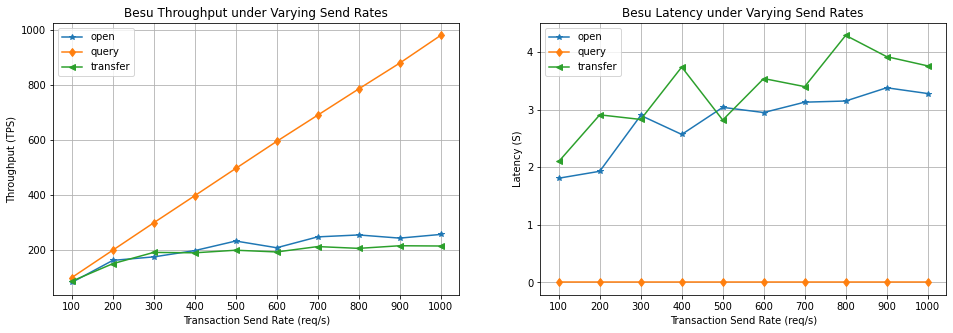

In [163]:
reports_path = '../caliper-benchmarks/reports/20220224-205152-7-2sec'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=7.89)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

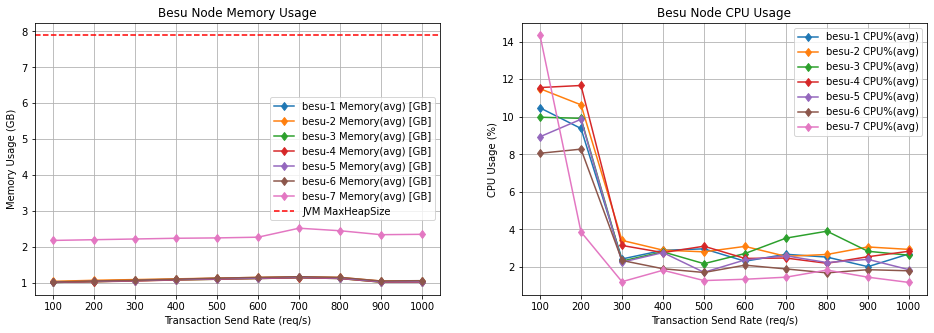

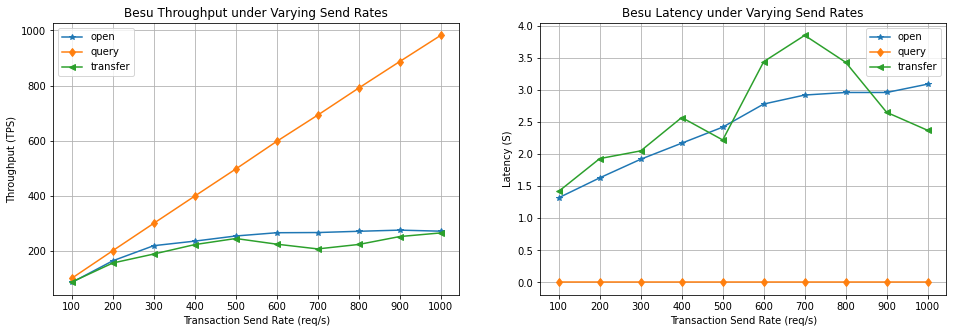

In [165]:
reports_path = '../caliper-benchmarks/reports/20220225-203936-7-2sec'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=7.89)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

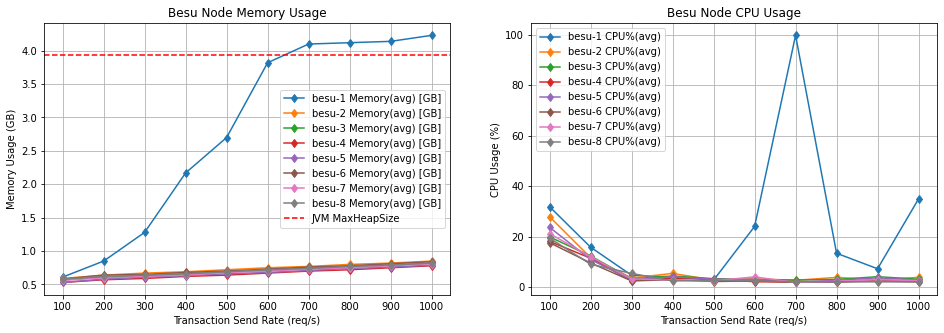

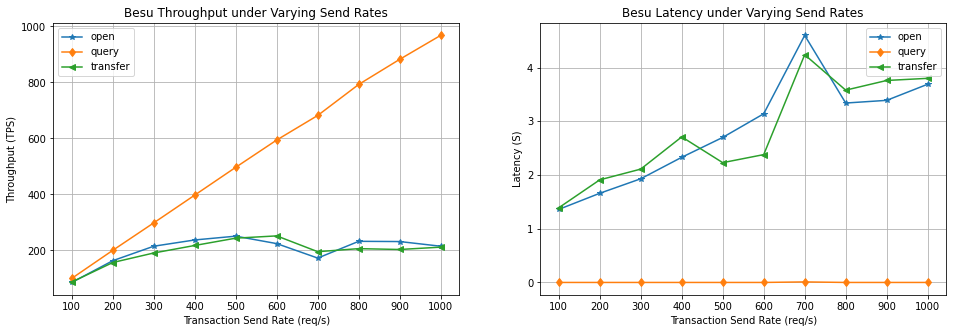

In [161]:
reports_path = '../caliper-benchmarks/reports/20220224-015808-8-2sec'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=3.93)

df_perf= get_res_df(reports_path)
plot_perf(df_perf)

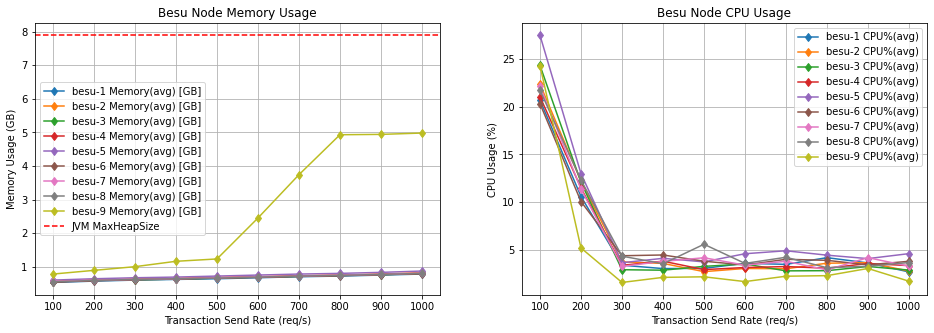

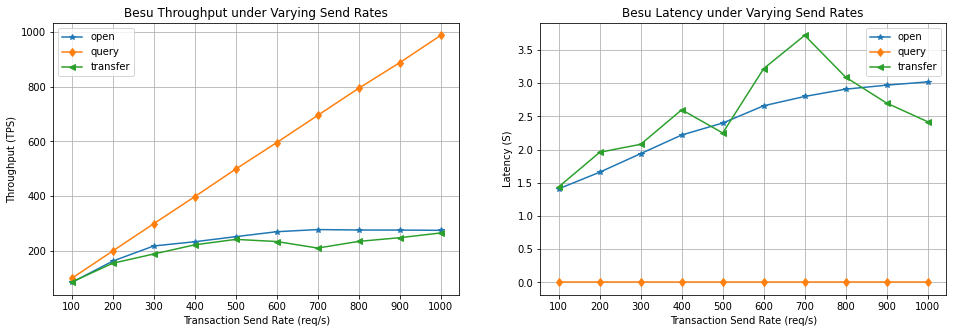

In [164]:
reports_path = '../caliper-benchmarks/reports/20220224-222415-9-2sec'
df = get_res_df(reports_path, monitor=True)
df.index = [index.split('/')[1] for index in df.index]
df_resource = df.drop(labels = df.columns[4:8], axis=1)
plot_resource(df_resource, jvm_max_heap=7.89)

df_perf = get_res_df(reports_path)
plot_perf(df_perf)

In [4]:
path_reports_4nodes_1 = '../caliper-benchmarks/reports-20211129-152024'
path_reports_4nodes_2 = '../caliper-benchmarks/reports-20211130-140232'
path_reports_4nodes_3 = '../caliper-benchmarks/reports-20211130-162538'
sendrates = np.arange(50, 300, 50)
df_res_1 = get_res_df(path_reports_4nodes_1, sendrates)
df_res_2 = get_res_df(path_reports_4nodes_2, sendrates)
df_res_3 = get_res_df(path_reports_4nodes_3, sendrates)

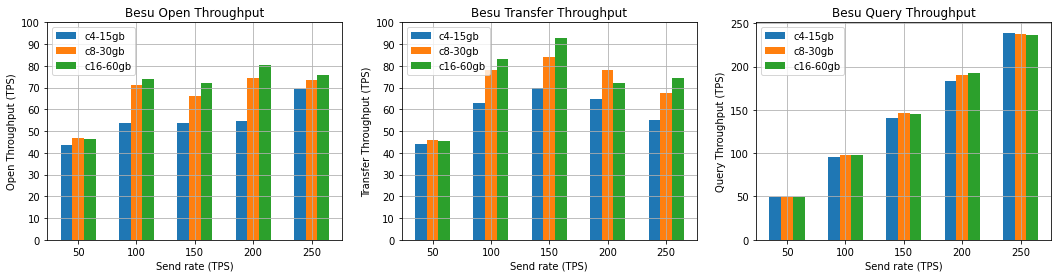

In [33]:
openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label='c4-15gb')
axs[0].bar(X_axis, openTPS_2, 0.2, label='c8-30gb')
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label='c16-60gb')
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label='c4-15gb')
axs[1].bar(X_axis, transferTPS_2, 0.2, label='c8-30gb')
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label='c16-60gb')
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label='c4-15gb')
axs[2].bar(X_axis, queryTPS_2, 0.2, label='c8-30gb')
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label='c16-60gb')
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')

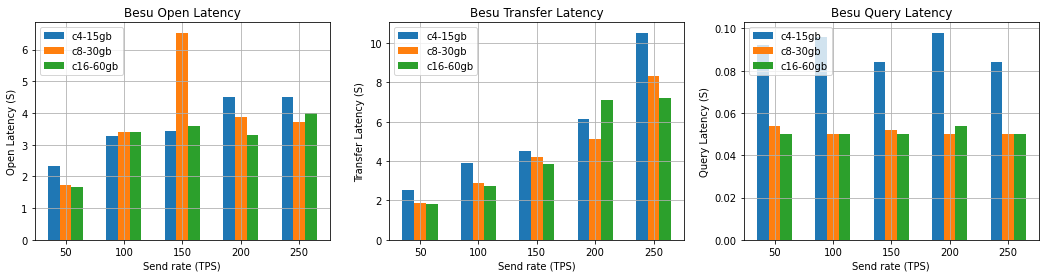

In [37]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label='c4-15gb')
axs[0].bar(X_axis, openLatency_2, 0.2, label='c8-30gb')
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label='c16-60gb')
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label='c4-15gb')
axs[1].bar(X_axis, transferLatency_2, 0.2, label='c8-30gb')
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label='c16-60gb')
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label='c4-15gb')
axs[2].bar(X_axis, queryLatency_2, 0.2, label='c8-30gb')
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label='c16-60gb')
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')

In [44]:
path_reports_4nodes_1 = '../caliper-benchmarks/reports/20211213-215339-2c4gb'
path_reports_4nodes_2 = '../caliper-benchmarks/reports/20211213-192953-4c8gb'
path_reports_4nodes_3 = '../caliper-benchmarks/reports/20211214-094805-8c8gb'
sendrates = np.arange(50, 300, 50)
df_res_1 = get_res_df(path_reports_4nodes_1, sendrates)
df_res_2 = get_res_df(path_reports_4nodes_2, sendrates)
df_res_3 = get_res_df(path_reports_4nodes_3, sendrates)

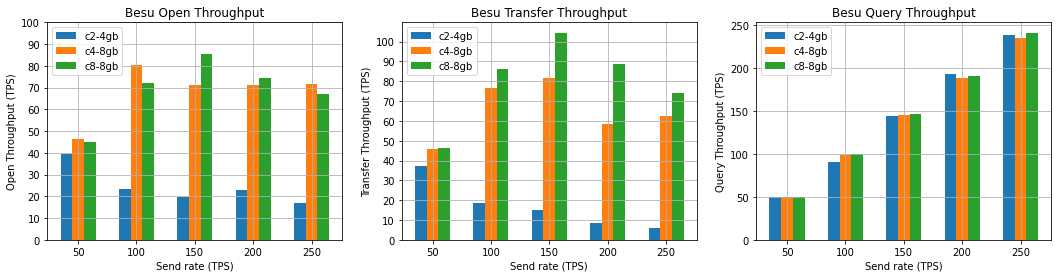

In [50]:
openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label='c2-4gb')
axs[0].bar(X_axis, openTPS_2, 0.2, label='c4-8gb')
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label='c8-8gb')
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label='c2-4gb')
axs[1].bar(X_axis, transferTPS_2, 0.2, label='c4-8gb')
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label='c8-8gb')
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label='c2-4gb')
axs[2].bar(X_axis, queryTPS_2, 0.2, label='c4-8gb')
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label='c8-8gb')
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')


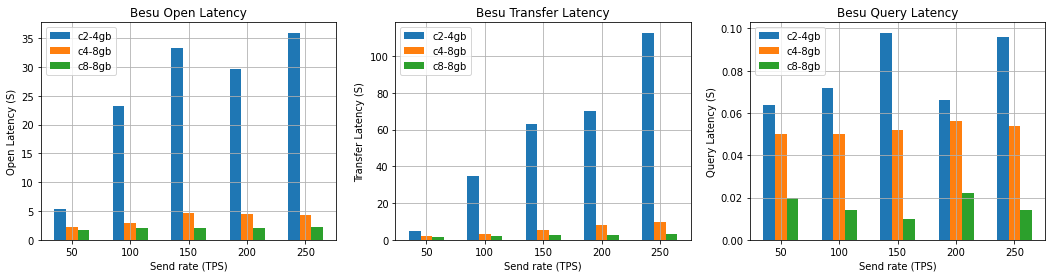

In [49]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label='c2-4gb')
axs[0].bar(X_axis, openLatency_2, 0.2, label='c4-8gb')
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label='c8-8gb')
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label='c2-4gb')
axs[1].bar(X_axis, transferLatency_2, 0.2, label='c4-8gb')
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label='c8-8gb')
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label='c2-4gb')
axs[2].bar(X_axis, queryLatency_2, 0.2, label='c4-8gb')
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label='c8-8gb')
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')

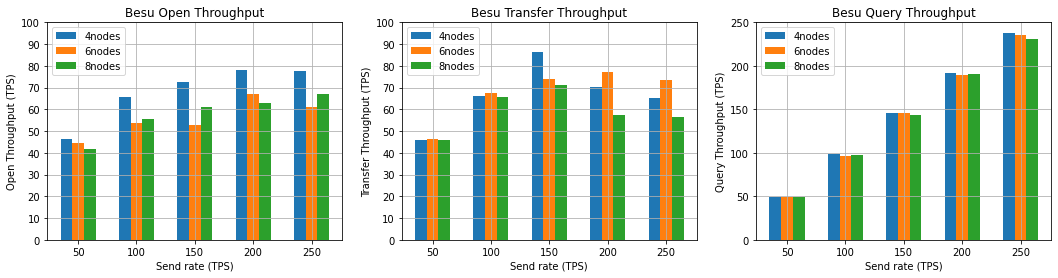

In [10]:
paths = ['../caliper-benchmarks/reports/20220126-200229-cyb-4', 
        '../caliper-benchmarks/reports/20220127-110556-cyb-6', 
        '../caliper-benchmarks/reports/20220127-144349-cyb-8']
sendrates = np.arange(50,300,50)
dfs = [get_res_df(path, sendrates) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)']
txTypes = ['open', 'query', 'transfer']
labels = ['4nodes', '6nodes', '8nodes']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']
Y_ticks = np.arange(0, 110, 10)
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set(title='Besu Open Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Open Throughput (TPS)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set(title='Besu Transfer Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks, ylabel='Transfer Throughput (TPS)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set(title='Besu Query Throughput', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, 
    yticks=Y_ticks_2, ylabel='Query Throughput (TPS)')
axs[2].grid()
axs[2].legend(loc='upper left')

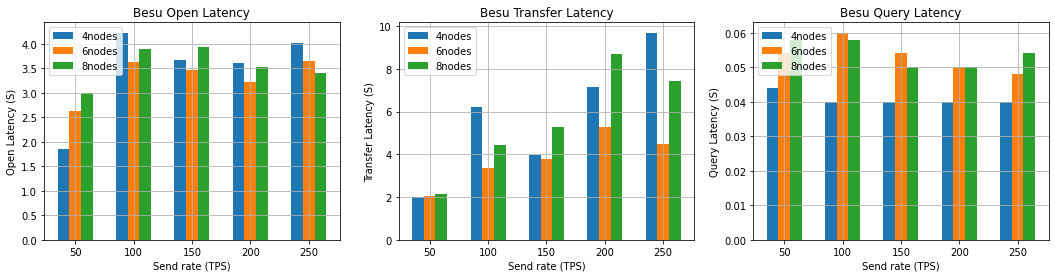

In [11]:
openLatency_1 = df_res_1[df_res_1.index=='open']['Avg Latency (s)'].values
openLatency_2 = df_res_2[df_res_2.index=='open']['Avg Latency (s)'].values
openLatency_3 = df_res_3[df_res_3.index=='open']['Avg Latency (s)'].values
queryLatency_1 = df_res_1[df_res_1.index=='query']['Avg Latency (s)'].values
queryLatency_2 = df_res_2[df_res_2.index=='query']['Avg Latency (s)'].values
queryLatency_3 = df_res_3[df_res_3.index=='query']['Avg Latency (s)'].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer']['Avg Latency (s)'].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer']['Avg Latency (s)'].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer']['Avg Latency (s)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = ['0','50', '100', '150', '200', '250']

axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set(title='Besu Open Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Open Latency (S)')
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set(title='Besu Transfer Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Transfer Latency (S)')
axs[1].grid()
axs[1].legend(loc='upper left')

Y_ticks_2 = np.arange(0, 300, 50)
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set(title='Besu Query Latency', 
    xlabel='Send rate (TPS)', xticklabels=X_labels, ylabel='Query Latency (S)')
axs[2].grid()
axs[2].legend(loc='upper left')

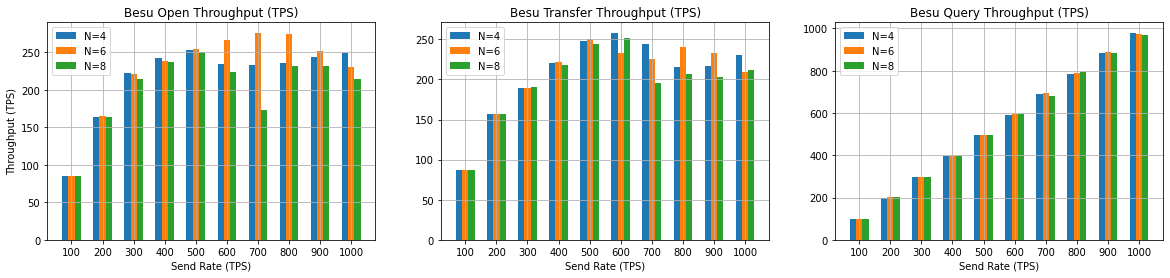

In [158]:
paths = ['../caliper-benchmarks/reports/20220223-163848-4-2sec', 
        '../caliper-benchmarks/reports/20220224-001139-6-2sec', 
        '../caliper-benchmarks/reports/20220224-015808-8-2sec']
dfs = [get_res_df(path) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
txTypes = ['open', 'query', 'transfer']
labels = ['N=4', 'N=6', 'N=8']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
sendrates = sorted(df_res_1.Rate.unique().astype(int))
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# axs[0].plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# axs[0].plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# axs[0].plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Throughput (TPS)', xlabel='Send Rate (TPS)', 
        ylabel='Throughput (TPS)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# axs[1].plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# axs[1].plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# axs[1].plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# axs[2].plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# axs[2].plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# axs[2].plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

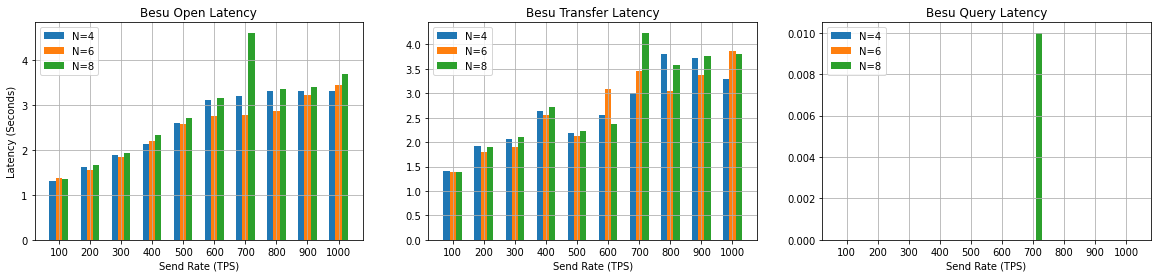

In [159]:
openLatency_1 = df_res_1[df_res_1.index=='open'][metrics[1]].values
openLatency_2 = df_res_2[df_res_2.index=='open'][metrics[1]].values
openLatency_3 = df_res_3[df_res_3.index=='open'][metrics[1]].values
queryLatency_1 = df_res_1[df_res_1.index=='query'][metrics[1]].values
queryLatency_2 = df_res_2[df_res_2.index=='query'][metrics[1]].values
queryLatency_3 = df_res_3[df_res_3.index=='query'][metrics[1]].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer'][metrics[1]].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer'][metrics[1]].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer'][metrics[1]].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# ax02 = axs[0].twinx()
# ax02.plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# ax02.plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# ax02.plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
# ax02.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Latency', xlabel='Send Rate (TPS)', 
                ylabel='Latency (Seconds)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# ax12 = axs[1].twinx()
# ax12.plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# ax12.plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# ax12.plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
# ax12.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# ax22 = axs[2].twinx()
# ax22.plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# ax22.plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# ax22.plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
# ax22.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

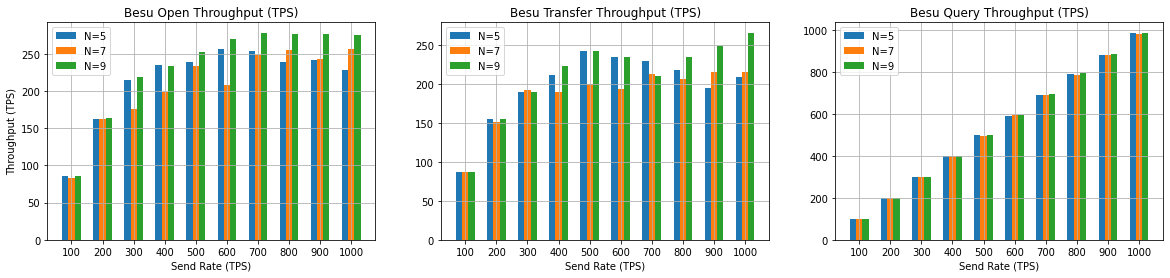

In [3]:
paths = ['../caliper-benchmarks/reports/20220223-215241-5-2sec', 
        '../caliper-benchmarks/reports/20220224-205152-7-2sec', 
        '../caliper-benchmarks/reports/20220224-222415-9-2sec']
dfs = [get_res_df(path) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
txTypes = ['open', 'query', 'transfer']
labels = ['N=5', 'N=7', 'N=9']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
sendrates = sorted(df_res_1.Rate.unique().astype(int))
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# axs[0].plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# axs[0].plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# axs[0].plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Throughput (TPS)', xlabel='Send Rate (TPS)', 
        ylabel='Throughput (TPS)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# axs[1].plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# axs[1].plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# axs[1].plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# axs[2].plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# axs[2].plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# axs[2].plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

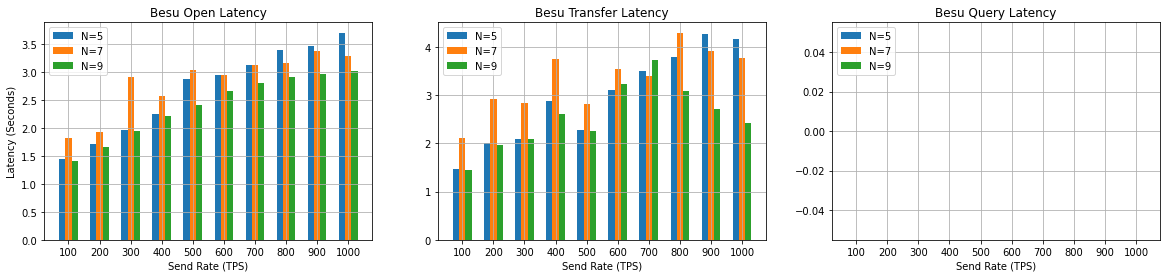

In [4]:
openLatency_1 = df_res_1[df_res_1.index=='open'][metrics[1]].values
openLatency_2 = df_res_2[df_res_2.index=='open'][metrics[1]].values
openLatency_3 = df_res_3[df_res_3.index=='open'][metrics[1]].values
queryLatency_1 = df_res_1[df_res_1.index=='query'][metrics[1]].values
queryLatency_2 = df_res_2[df_res_2.index=='query'][metrics[1]].values
queryLatency_3 = df_res_3[df_res_3.index=='query'][metrics[1]].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer'][metrics[1]].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer'][metrics[1]].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer'][metrics[1]].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = sendrates

# ax02 = axs[0].twinx()
# ax02.plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
# ax02.plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
# ax02.plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
# ax02.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Latency', xlabel='Send Rate (TPS)', 
                ylabel='Latency (Seconds)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

# ax12 = axs[1].twinx()
# ax12.plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
# ax12.plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
# ax12.plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
# ax12.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

# ax22 = axs[2].twinx()
# ax22.plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
# ax22.plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
# ax22.plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
# ax22.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

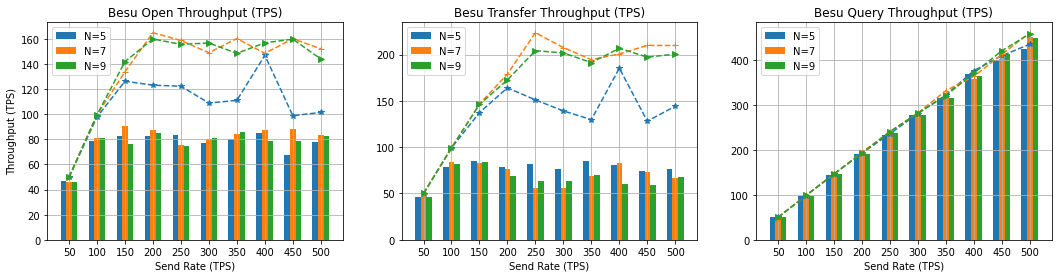

In [87]:
paths = ['../caliper-benchmarks/reports/20220209-115312-cc-5', 
        '../caliper-benchmarks/reports/20220211-223944-cc-7', 
        '../caliper-benchmarks/reports/20220212-130711-cc-9']
sendrates = np.arange(50,550,50)
dfs = [get_res_df(path, sendrates) for path in paths]
df_res_1, df_res_2, df_res_3 = dfs[0], dfs[1], dfs[2]

metrics = ['Throughput (TPS)', 'Avg Latency (s)', 'Send Rate (TPS)']
txTypes = ['open', 'query', 'transfer']
labels = ['N=5', 'N=7', 'N=9']

openTPS_1 = df_res_1[df_res_1.index=='open']['Throughput (TPS)'].values
openTPS_2 = df_res_2[df_res_2.index=='open']['Throughput (TPS)'].values
openTPS_3 = df_res_3[df_res_3.index=='open']['Throughput (TPS)'].values
queryTPS_1 = df_res_1[df_res_1.index=='query']['Throughput (TPS)'].values
queryTPS_2 = df_res_2[df_res_2.index=='query']['Throughput (TPS)'].values
queryTPS_3 = df_res_3[df_res_3.index=='query']['Throughput (TPS)'].values
transferTPS_1 = df_res_1[df_res_1.index=='transfer']['Throughput (TPS)'].values
transferTPS_2 = df_res_2[df_res_2.index=='transfer']['Throughput (TPS)'].values
transferTPS_3 = df_res_3[df_res_3.index=='transfer']['Throughput (TPS)'].values

fig, axs = plt.subplots(figsize=(18,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = [50 * (x+1) for x in X_axis]

axs[0].plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
axs[0].plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
axs[0].plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
axs[0].bar(X_axis - 0.2, openTPS_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openTPS_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openTPS_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Throughput (TPS)', xlabel='Send Rate (TPS)', 
        ylabel='Throughput (TPS)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
axs[1].plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
axs[1].plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
axs[1].bar(X_axis - 0.2, transferTPS_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferTPS_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferTPS_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

axs[2].plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
axs[2].plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
axs[2].plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
axs[2].bar(X_axis - 0.2, queryTPS_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryTPS_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryTPS_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Throughput (TPS)', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

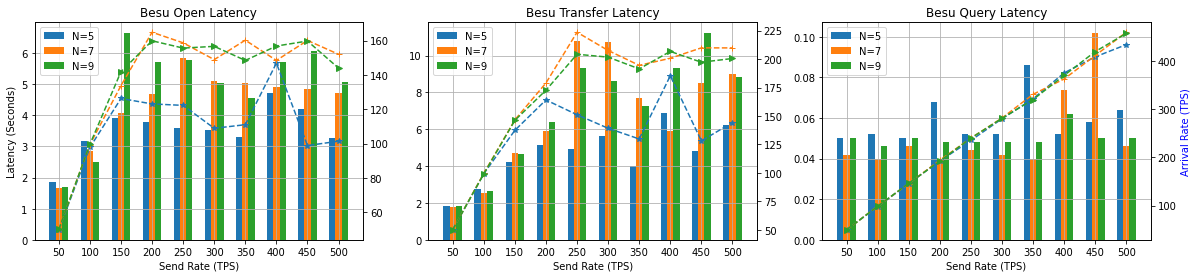

In [85]:
openLatency_1 = df_res_1[df_res_1.index=='open'][metrics[1]].values
openLatency_2 = df_res_2[df_res_2.index=='open'][metrics[1]].values
openLatency_3 = df_res_3[df_res_3.index=='open'][metrics[1]].values
queryLatency_1 = df_res_1[df_res_1.index=='query'][metrics[1]].values
queryLatency_2 = df_res_2[df_res_2.index=='query'][metrics[1]].values
queryLatency_3 = df_res_3[df_res_3.index=='query'][metrics[1]].values
transferLatency_1 = df_res_1[df_res_1.index=='transfer'][metrics[1]].values
transferLatency_2 = df_res_2[df_res_2.index=='transfer'][metrics[1]].values
transferLatency_3 = df_res_3[df_res_3.index=='transfer'][metrics[1]].values

fig, axs = plt.subplots(figsize=(20,4), ncols=3, nrows=1)
X_axis = np.arange(len(sendrates))
X_labels = [50 * (x+1) for x in X_axis]

ax02 = axs[0].twinx()
ax02.plot(X_axis, df_res_1[df_res_1.index==txTypes[0]][metrics[2]].values, '--', marker='*')
ax02.plot(X_axis, df_res_2[df_res_2.index==txTypes[0]][metrics[2]].values, '--', marker='+')
ax02.plot(X_axis, df_res_3[df_res_3.index==txTypes[0]][metrics[2]].values, '--', marker='>')
# ax02.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[0].bar(X_axis - 0.2, openLatency_1, 0.2, label=labels[0])
axs[0].bar(X_axis, openLatency_2, 0.2, label=labels[1])
axs[0].bar(X_axis + 0.2, openLatency_3, 0.2, label=labels[2])
axs[0].set_xticks(X_axis)
axs[0].set(title='Besu Open Latency', xlabel='Send Rate (TPS)', 
                ylabel='Latency (Seconds)', xticklabels=X_labels)
axs[0].grid()
axs[0].legend(loc='upper left')

ax12 = axs[1].twinx()
ax12.plot(X_axis, df_res_1[df_res_1.index==txTypes[2]][metrics[2]].values, '--', marker='*')
ax12.plot(X_axis, df_res_2[df_res_2.index==txTypes[2]][metrics[2]].values, '--', marker='+')
ax12.plot(X_axis, df_res_3[df_res_3.index==txTypes[2]][metrics[2]].values, '--', marker='>')
# ax12.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[1].bar(X_axis - 0.2, transferLatency_1, 0.2, label=labels[0])
axs[1].bar(X_axis, transferLatency_2, 0.2, label=labels[1])
axs[1].bar(X_axis + 0.2, transferLatency_3, 0.2, label=labels[2])
axs[1].set_xticks(X_axis)
axs[1].set(title='Besu Transfer Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[1].grid()
axs[1].legend(loc='upper left')

ax22 = axs[2].twinx()
ax22.plot(X_axis, df_res_1[df_res_1.index==txTypes[1]][metrics[2]].values, '--', marker='*')
ax22.plot(X_axis, df_res_2[df_res_2.index==txTypes[1]][metrics[2]].values, '--', marker='+')
ax22.plot(X_axis, df_res_3[df_res_3.index==txTypes[1]][metrics[2]].values, '--', marker='>')
ax22.set_ylabel("Arrival Rate (TPS)", color="blue")
axs[2].bar(X_axis - 0.2, queryLatency_1, 0.2, label=labels[0])
axs[2].bar(X_axis, queryLatency_2, 0.2, label=labels[1])
axs[2].bar(X_axis + 0.2, queryLatency_3, 0.2, label=labels[2])
axs[2].set_xticks(X_axis)
axs[2].set(title='Besu Query Latency', xlabel='Send Rate (TPS)', xticklabels=X_labels)
axs[2].grid()
axs[2].legend(loc='upper left')

In [2]:
import pandas as pd

df = pd.read_csv('../data/TX_Num_ in_head_block.csv', parse_dates=True)
df.columns = ['Time', 'TX_num']

In [3]:
# 1450 1640
df = df[(df.Time > '2022-02-17 14:50:00') & (df.Time <= '2022-02-17 16:40:00')]

In [24]:
df

,Time,TX_num
151,2022-02-17 14:50:20,0
152,2022-02-17 14:50:40,0
153,2022-02-17 14:51:00,100
154,2022-02-17 14:51:20,0
155,2022-02-17 14:51:40,0
...,...,...
476,2022-02-17 16:38:40,0
477,2022-02-17 16:39:00,0
478,2022-02-17 16:39:20,186
479,2022-02-17 16:39:40,0


<AxesSubplot:>

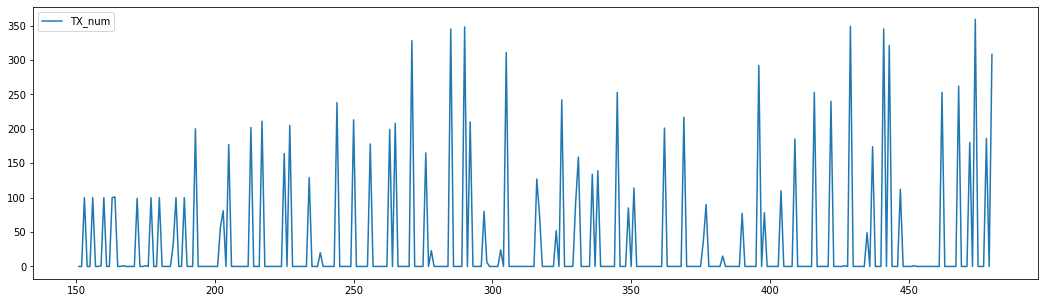

In [23]:
df.plot(figsize=(18,5))

<AxesSubplot:>

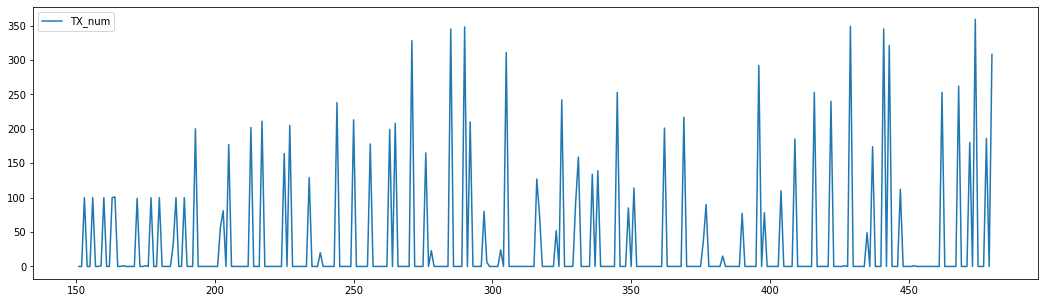

In [5]:
df[['Time', 'TX_num']].plot(figsize=(18,5))

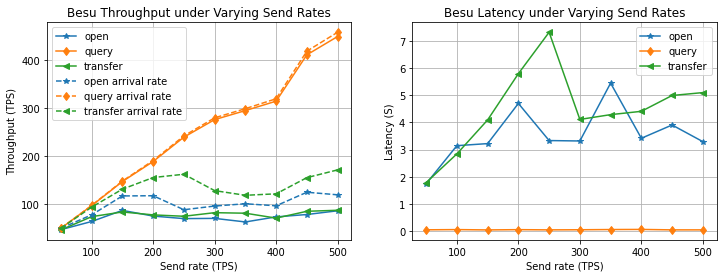

In [21]:
path = '../caliper-benchmarks/reports/20220217-144854'
sendrates = np.arange(50,550,50)
df_res = get_res_df(path, sendrates)
plot_perf(df_res, True)

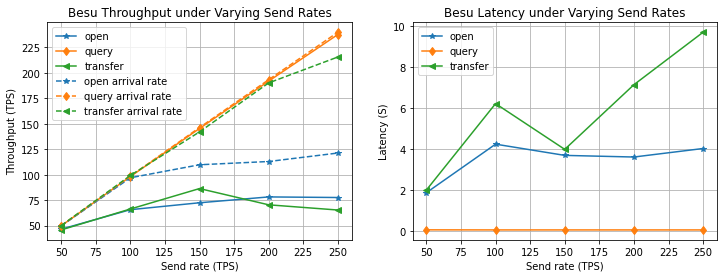

In [26]:
path = '../caliper-benchmarks/reports/20220126-200229-cyb-4'
sendrates = np.arange(50,300,50)
df_res = get_res_df(path, sendrates)
plot_perf(df_res, True)

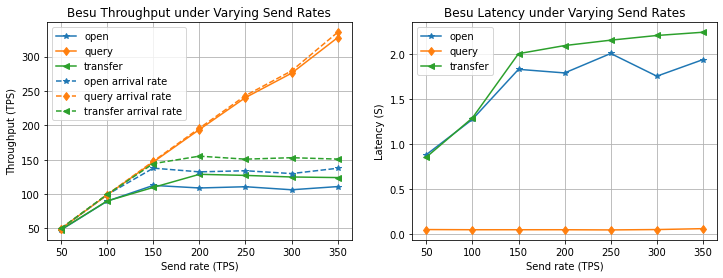

In [8]:
path = '../caliper-benchmarks/reports/20220220-235043'
sendrates = np.arange(50,400,50)
df_res = get_res_df(path, sendrates)
plot_perf(df_res, True)

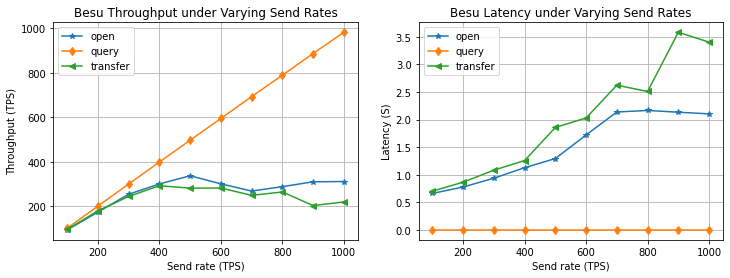

In [16]:
path = '../caliper-benchmarks/reports/20220223-004031-cloud-4-1sec'
sendrates = np.arange(100,1100,100)
df_res = get_res_df(path, sendrates)
plot_perf(df_res)

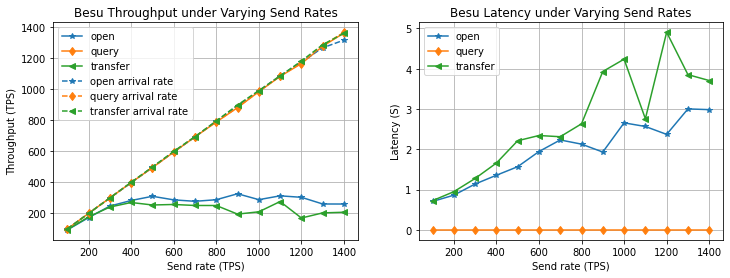

In [17]:
path = '../caliper-benchmarks/reports/20220223-015603-cloud-4-1sec'
sendrates = np.arange(100,1500,100)
df_res = get_res_df(path, sendrates)
plot_perf(df_res, True)

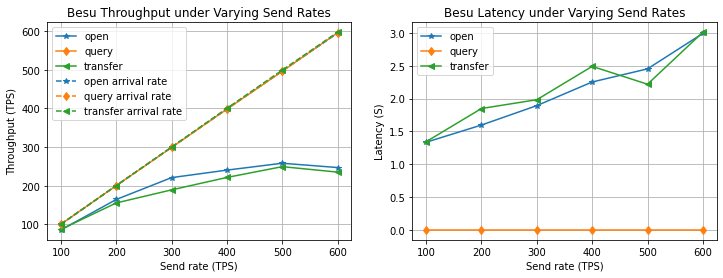

In [13]:
path = '../caliper-benchmarks/reports/20220223-050753-4-2sec'
df_res = get_res_df(path)
plot_perf(df_res, True)

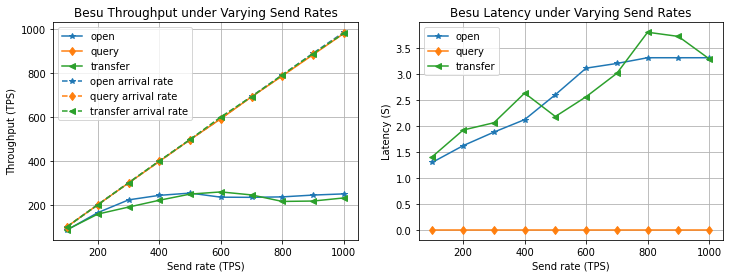

In [44]:
path = '../caliper-benchmarks/reports/20220223-163848-4-2sec'
df_res = get_res_df(path)
plot_perf(df_res, True)